In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [2]:
# Download NLTK resources (uncomment the lines below if needed)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vinay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vinay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vinay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# Load the dataset
df = pd.read_csv('fake_job_postings.csv')

In [4]:
print(df.columns)

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')


In [5]:
print(df.head())

   job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Foo

In [6]:
# Function to preprocess text
def preprocess_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()

        # Remove links
        text = re.sub(r'http\S+', '', text)

        # Remove next lines (\n)
        text = text.replace('\n', ' ')

        # Remove words containing numbers
        text = re.sub(r'\w*\d\w*', '', text)

        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text)

        # Remove special characters
        text = re.sub(r'[^\w\s]', '', text)

        return text.strip()
    else:
        return ''

# Apply pre-processing to 'description' column
df['clean_description'] = df['description'].apply(preprocess_text)

In [7]:
# Removal of stop words and stemming
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [8]:
def remove_stopwords_and_stem(text):
    words = nltk.word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    stemmed_words = [stemmer.stem(word) for word in filtered_words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]
    return ' '.join(lemmatized_words)

In [9]:
# Apply remove_stopwords_and_stem to 'clean_description' column
df['clean_description'] = df['clean_description'].apply(remove_stopwords_and_stem)

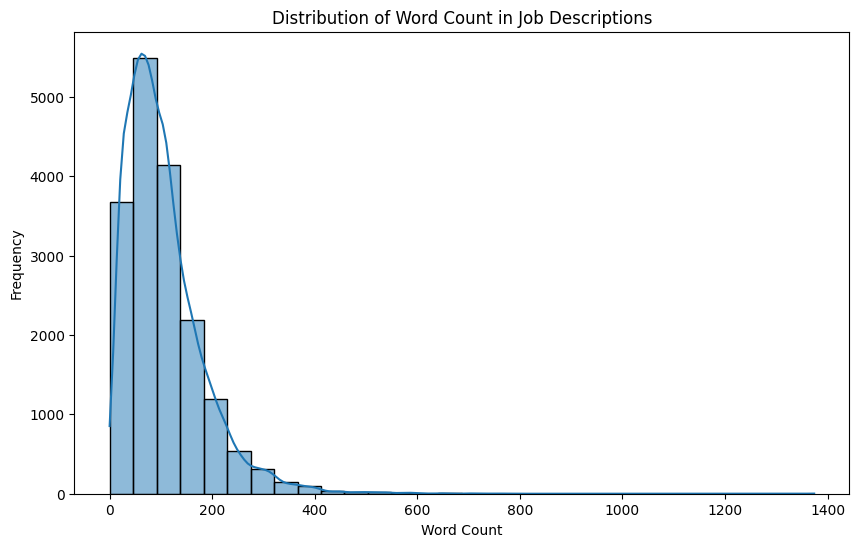

In [10]:
# Plotting relationships between features
# Example: Plot word count distribution
df['word_count'] = df['clean_description'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=30, kde=True)
plt.title('Distribution of Word Count in Job Descriptions')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

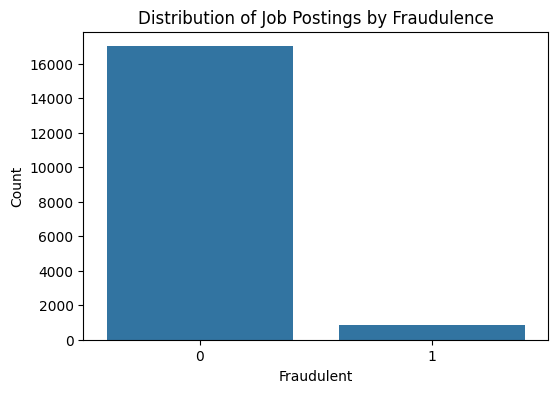

In [11]:
# Example: Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='fraudulent', data=df)
plt.title('Distribution of Job Postings by Fraudulence')
plt.xlabel('Fraudulent')
plt.ylabel('Count')
plt.show()

2. Feature engineering

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
tfidf_features = tfidf_vectorizer.fit_transform(df['clean_description']).toarray()

# Create a DataFrame from TF-IDF features
tfidf_df = pd.DataFrame(tfidf_features, columns=tfidf_vectorizer.get_feature_names_out())

# Encoding categorical variables
cat_cols = ['employment_type', 'required_experience', 'required_education', 'industry', 'function']
encoded_features = pd.DataFrame()

for col in cat_cols:
    le = LabelEncoder()
    encoded_feature = le.fit_transform(df[col].astype(str))
    encoded_features[col] = encoded_feature

# Concatenate TF-IDF features with encoded categorical features
final_features = pd.concat([tfidf_df, encoded_features], axis=1)

# Optionally, scale numerical features
# scaler = StandardScaler()
# final_features_scaled = scaler.fit_transform(final_features)

# Add target variable 'fraudulent' to final features DataFrame
final_features['fraudulent'] = df['fraudulent']

# Display the final feature DataFrame
print(final_features.head())

# Example: Splitting into Train (70%), Test (20%), Validation (10%) datasets
X = final_features.drop('fraudulent', axis=1)
y = final_features['fraudulent']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

# Display shapes of the datasets
print(f"Train set shape: {X_train.shape}, Validation set shape: {X_val.shape}, Test set shape: {X_test.shape}")


   aan   ab  ab test  abc  abc suppli  abil  abil adapt  abil build  \
0  0.0  0.0      0.0  0.0         0.0   0.0         0.0         0.0   
1  0.0  0.0      0.0  0.0         0.0   0.0         0.0         0.0   
2  0.0  0.0      0.0  0.0         0.0   0.0         0.0         0.0   
3  0.0  0.0      0.0  0.0         0.0   0.0         0.0         0.0   
4  0.0  0.0      0.0  0.0         0.0   0.0         0.0         0.0   

   abil commun  abil demonstr  ...  την  της   το  του  employment_type  \
0          0.0            0.0  ...  0.0  0.0  0.0  0.0                2   
1          0.0            0.0  ...  0.0  0.0  0.0  0.0                1   
2          0.0            0.0  ...  0.0  0.0  0.0  0.0                5   
3          0.0            0.0  ...  0.0  0.0  0.0  0.0                1   
4          0.0            0.0  ...  0.0  0.0  0.0  0.0                1   

   required_experience  required_education  industry  function  fraudulent  
0                    4                  13   

Model 1: RANDOM FOREST

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=28)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predictions
y_pred_train_rf = rf_classifier.predict(X_train)
y_pred_val_rf = rf_classifier.predict(X_val)
y_pred_test_rf = rf_classifier.predict(X_test)

# Evaluate the model
print("Random Forest Model Metrics:")
print("Training Set:")
print(classification_report(y_train, y_pred_train_rf))
print("Validation Set:")
print(classification_report(y_val, y_pred_val_rf))
print("Test Set:")
print(classification_report(y_test, y_pred_test_rf))

# Confusion Matrix
print("Confusion Matrix - Test Set:")
print(confusion_matrix(y_test, y_pred_test_rf))

# Accuracy
accuracy_rf = accuracy_score(y_test, y_pred_test_rf)
print(f"Accuracy: {accuracy_rf}")


Random Forest Model Metrics:
Training Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11921
           1       1.00      1.00      1.00       595

    accuracy                           1.00     12516
   macro avg       1.00      1.00      1.00     12516
weighted avg       1.00      1.00      1.00     12516

Validation Set:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3421
           1       0.98      0.53      0.69       172

    accuracy                           0.98      3593
   macro avg       0.98      0.77      0.84      3593
weighted avg       0.98      0.98      0.97      3593

Test Set:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1672
           1       0.96      0.52      0.67        99

    accuracy                           0.97      1771
   macro avg       0.97      0.76      0.83      1771
weigh

MODEL 2: LSTM

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['clean_description'])
sequences = tokenizer.texts_to_sequences(df['clean_description'])

# Padding sequences
maxlen = 100
X_padded = pad_sequences(sequences, maxlen=maxlen)

# Splitting the data
X_train, X_temp, y_train, y_temp = train_test_split(X_padded, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

# Building the LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=5000, output_dim=128, input_length=maxlen))
lstm_model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
lstm_model.add(Dropout(0.5))
lstm_model.add(Bidirectional(LSTM(units=32)))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the LSTM model
lstm_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

# Evaluating the LSTM model
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test)
print(f"LSTM Model Accuracy: {lstm_accuracy}")


c:\Users\Vinay\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 33s 118ms/step - accuracy: 0.9352 - loss: 0.2517 - val_accuracy: 0.9697 - val_loss: 0.1160
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.9718 - loss: 0.0956 - val_accuracy: 0.9727 - val_loss: 0.0984
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 110ms/step - accuracy: 0.9856 - loss: 0.0519 - val_accuracy: 0.9750 - val_loss: 0.1049
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.9937 - loss: 0.0216 - val_accuracy: 0.9730 - val_loss: 0.1214
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 110ms/step - accuracy: 0.9969 - loss: 0.0123 - val_accuracy: 0.9730 - val_loss: 0.1422
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 110ms/step - accuracy: 0.9954 - loss: 0.0146 - val_accuracy: 0.9741 - val_loss: 0.1461
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 111ms/step - accuracy: 0.9983 - loss: 0.0057 - val_accuracy: 0.9711 - val_loss: 0.1508
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 22s 114ms/step - accuracy: 0.9992 - loss: 0

#PLOTS

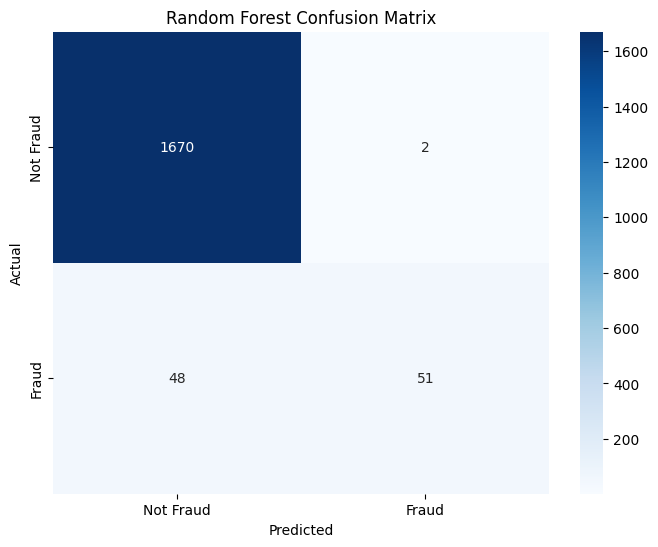

In [16]:

# Visualization of Random Forest Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_test_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step


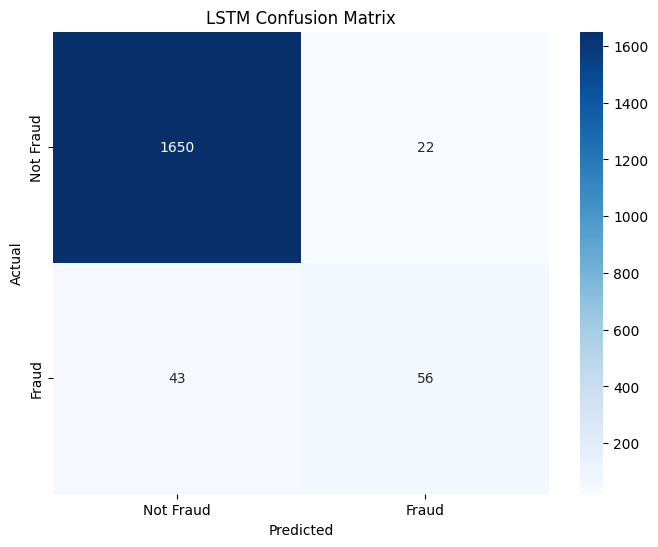

In [17]:

# Visualization of LSTM Confusion Matrix
y_pred_test_lstm = (lstm_model.predict(X_test) > 0.5).astype("int32")
conf_matrix_lstm = confusion_matrix(y_test, y_pred_test_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lstm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [18]:
import joblib

# Save the model
joblib.dump(rf_classifier, 'random_forest_model.pkl')


['random_forest_model.pkl']

In [19]:
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import joblib

# Assuming df is your DataFrame and 'title' is the text column
titles = df['title'].apply(preprocess_text)

# Train TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(titles)

# Train Random Forest model
model = RandomForestClassifier()
model.fit(X_tfidf, df['fraudulent'])

# Save the vectorizer and model
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(model, 'random_forest_model.pkl')

['random_forest_model.pkl']